# Neural nets with a practical example

### Mike Smith (University of Hertfordshire)

Today we're going to diagnose myocardial infarctions (heart attacks) using a feedforward neural network written in pytorch.

## Download the ECG dataset

You can find it nicely packaged here: https://www.kaggle.com/openmark/ptb-diagnostic-ecg-database

In [1]:
import numpy as np
import pandas as pd

In [2]:
ecgs = np.load("data/data_raw.npz")
meta = pd.read_csv("data/meta.csv", quotechar='"', delimiter=",")
meta.head(3)

,patient,record_id,fs,sig_len,n_sig,base_date,base_time,units,sig_name,age,...,Therapy,Infarction_date,Admission_date,Medication_pre_admission,Start_lysis_therapy_(hh.mm),Lytic_agent,Dosage_(lytic_agent),Additional_medication,In_hospital_medication,Medication_after_discharge
0,patient001,s0010_re,1000,38400,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,...,NaN,29-Sep-90,29-Sep-90,Isosorbit-Dinitrate Digoxin Glibenclamide,19,Gamma-TPA,30 mg,Heparin Isosorbit-Mononitrate ASA Diazepam,ASA Isosorbit-Mononitrate Ca-antagonist Amilor...,ASA Isosorbit-Mononitrate Amiloride+Chlorothia...
1,patient001,s0014lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,...,NaN,29-Sep-90,29-Sep-90,Isosorbit-Dinitrate Digoxin Glibenclamide,19,Gamma-TPA,30 mg,Heparin Isosorbit-Mononitrate ASA Diazepam,ASA Isosorbit-Mononitrate Ca-antagonist Amilor...,ASA Isosorbit-Mononitrate Amiloride+Chlorothia...
2,patient001,s0016lre,1000,115200,15,NaN,NaN,"['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV...","['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', ...",81.0,...,NaN,29-Sep-90,29-Sep-90,Isosorbit-Dinitrate Digoxin Glibenclamide,19,Gamma-TPA,30 mg,Heparin Isosorbit-Mononitrate ASA Diazepam,ASA Isosorbit-Mononitrate Ca-antagonist Amilor...,ASA Isosorbit-Mononitrate Amiloride+Chlorothia...


## Where are these leads from?

![limb leads](figs/limb_leads.png)
![v1-6](figs/v1-6.png)

# A typical ECG's anatomy

![ecg](./figs/ecg.png)

![ecggif](./figs/ecg.gif)

In [3]:
import matplotlib.pyplot as plt

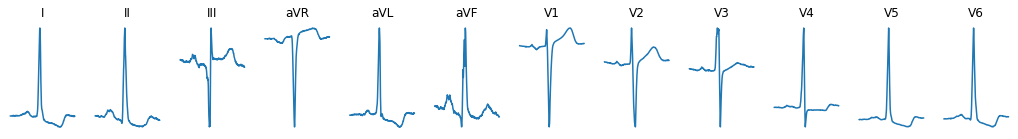

In [4]:
f, axs = plt.subplots(1, 12, figsize=(18, 2))
for i, ax, lead in zip(range(12), axs.ravel(), ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]):
    ax.set_title(lead)
    ax.axis("off")
    ax.plot(ecgs["patient212/s0434_re"][400:1100, i])

# What does the dataset look like?:

We're going to look for patient's with a myocardial infarction (which typically induces ST-elevation).

![st-elev](./figs/ecg_stelevation_mi.jpg)

In [5]:
diagnoses = meta[["patient", "record_id", "Reason_for_admission"]]
healthies = diagnoses[(diagnoses["Reason_for_admission"] == "Healthy control")]
ills = diagnoses[(diagnoses["Reason_for_admission"] == "Myocardial infarction")]
print("We have {} ill patients and {} healthy patients!".format(len(set(ills["patient"])), len(set(healthies["patient"]))))

We have 148 ill patients and 52 healthy patients!


## Let's split the patients into training and test sets (+ populate those sets with individual scans):

We want to balance the training and testing sets so that they contain roughly similar amounts of ECG scans

In [6]:
testing_patients = (list(set(healthies["patient"]))[40:52], list(set(ills["patient"]))[120:148])
training_patients = (list(set(healthies["patient"]))[:40], list(set(ills["patient"]))[:120])

In [7]:
from scipy.signal import find_peaks

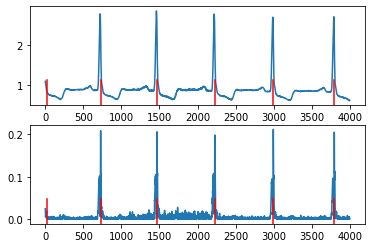

In [8]:
# We want mitigate ECG "walk" where the ECG signal moves from a level signal.
# We can do this by taking the differential of the ECG signal.
# If we then take the absolute value of this we can easily detect the QRS complexes using scipy.signal.find_peaks.

# Once we get the locations of the QRS complexes we can crop out a full ECG scan, and populate a numpy array with them.
f, axs = plt.subplots(2, 1)
axs[0].plot(ecgs["patient212/s0434_re"][:4000, 0])
axs[1].plot(np.abs(np.diff(ecgs["patient212/s0434_re"][:4000, 0])))

# Find peaks:
peaks, _ = find_peaks(np.abs(np.diff(ecgs["patient212/s0434_re"][:4000, 0])), distance=500)
[axs[0].axvline(peak, 0, 0.25, color="r") for peak in peaks]
[axs[1].axvline(peak, 0, 0.25, color="r") for peak in peaks]
plt.show()

In [9]:
import tqdm

In [10]:
def populate_array(patients):
    """
    Populate an array of ECG scans given a list of patients.
    """
    scans = []
    for name in tqdm.tqdm(ecgs.files):
        if name.split("/")[0] in patients:
            qrss, _ = find_peaks(np.abs(np.diff(ecgs[name][:, 0])), distance=500)
            raw_ecgs = ecgs[name]
            for qrs in qrss:
                if raw_ecgs[qrs - 300:qrs + 300, :12].shape == (600, 12):
                    scans.append(raw_ecgs[qrs - 300:qrs + 300, :12])
            del raw_ecgs # we need to do this to stop a memory leak...
                
    return np.array(scans)

# Generate training set
training_set = (populate_array(training_patients[0]), populate_array(training_patients[1]))
# Balance training set
smallest_set = np.min((len(training_set[0]), len(training_set[1])))
print(smallest_set, "(x2) in the training set")
training_set = np.concatenate((training_set[0][:smallest_set], training_set[1][:smallest_set]), axis=0)
training_labels = np.concatenate((np.zeros(smallest_set), np.ones(smallest_set)), axis=0)

# Generate testing set
testing_set = (populate_array(testing_patients[0]), populate_array(testing_patients[1]))
# Balance testing set
smallest_set = np.min((len(testing_set[0]), len(testing_set[1])))
print(smallest_set, "(x2) in the testing set")
testing_set = np.concatenate((testing_set[0][:smallest_set], testing_set[1][:smallest_set]), axis=0)
testing_labels = np.concatenate((np.zeros(smallest_set), np.ones(smallest_set)), axis=0)

100%|██████████| 549/549 [00:29<00:00, 18.57it/s]


8998 (x2) in the training set


100%|██████████| 549/549 [00:07<00:00, 76.73it/s]


3990 (x2) in the testing set


In [13]:
# Normalise training and test sets
def min_max_norm(ar):
    return (ar - ar.min())/(ar.max() - ar.min())

training_set = [min_max_norm(ecg) for ecg in training_set]
testing_set = [min_max_norm(ecg) for ecg in testing_set]

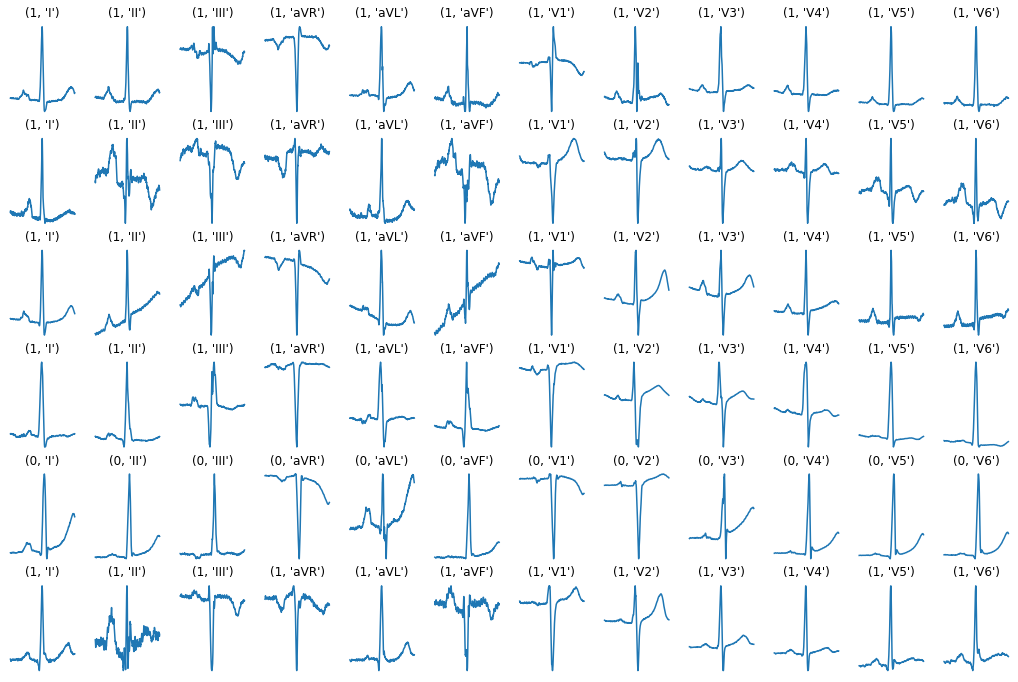

In [14]:
f, axs = plt.subplots(6, 12, figsize=(18, 12))
for i in range(6):
    rand_choice = np.random.randint(0, len(training_set))
    ecg = training_set[rand_choice]
    label = training_labels[rand_choice]
    for j, ax, lead in zip(range(12), axs[i].ravel(), ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]):
        axs[i, j].set_title((int(label), lead))
        ax.axis("off")
        ax.plot(ecg[:, j])

# Now we have the training and testing sets, let's start writing the ANN

We'll use a modified version of Lecun's LeNet-5, developed in the late 80s for OCR (some papers using the model are found [here](http://yann.lecun.com/exdb/lenet/)).

![lenet-5](figs/lenet-5.png)

Figure from ["Gradient-Based Learning Applied to Document Recognition", Y. LeCun et al. 1998](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf).

## What is a fully connected layer?

A layer made up of many artificial neurons:

<img src="figs/AN.png" width=400>

Example of a fully connected neural network binary classifier:

<img src="figs/ANN.png" width=600>

## What's a convolution?

[![conv](figs/conv.gif)](http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/)

## Grad descent

[![gdesc](figs/gradient_descent.gif)](http://vis.supstat.com/2013/03/gradient-descent-algorithm-with-r/)

We'll write the network in PyTorch because it's nice to work with.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Our ECGNet will be the same as LeCun's LeNet 5 (with 1D CNNs in place of 2D CNNs)

In [16]:
class EcgNet(nn.Module):
    
    def __init__(self):
        super(EcgNet, self).__init__()
        
        self.conv1 = nn.Conv1d(12, 16, 3)
        self.conv2 = nn.Conv1d(16, 32, 3)
        
        self.fc1 = nn.Linear(32 * 148, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        # a 1D max pool over the length of the ECG
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        # Reshape ready for input into FC layer
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
ecgnet = EcgNet()
print(ecgnet)

EcgNet(
  (conv1): Conv1d(12, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=4736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [17]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Let's define an accuracy metric:

In [18]:
def accuracy(ys, ps):
    acc = (torch.round(ys) == torch.round(ps)).float().detach().numpy()
    return float(acc.sum()/len(acc))

and the optimiser + criterion (loss). We'll use [Adam](https://arxiv.org/abs/1412.6980) and [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html):

In [ ]:
optimiser = optim.Adam(ecgnet.parameters(), lr=0.001)
criterion = nn.BCELoss()

Some init stuff:

In [ ]:
epochs = 6
batch_size = 16

x_train, x_valid, y_train, y_valid = train_test_split(training_set, training_labels, test_size=0.20)

losses = []
accs = []
global_vlosses = []
global_vaccs = []

and the training loop:

In [19]:
for epoch in range(epochs):
    print(epoch, "/", epochs - 1)
    # Shuffle the training set before each epoch
    x_train, y_train = shuffle(x_train, y_train)
    
    t = tqdm.trange(0, len(x_train), batch_size) # This gives us a nice progress bar
    
    for step in t:
        optimiser.zero_grad() # Remove all gradients before training
        
        # Get a single batch and populate ys, xs, ps:
        ys = y_train[step:step + batch_size]
        ys = torch.from_numpy(np.array(ys)[..., np.newaxis]).float()
        xs = x_train[step:step + batch_size]
        xs = torch.from_numpy(np.array(xs).swapaxes(1, 2))
        ps = ecgnet(xs)
        
        # Get the loss
        loss = criterion(ps, ys)
        # Get the accuracy for us (NN doesn't use this here)
        acc = accuracy(ps, ys)
        
        losses.append(loss.item())
        accs.append(acc)
        t.set_description("{:.04f}, {:.04f}".format(loss.item(), acc))
        
        # Backpropagate the loss through the network and update the weights to follow the loss down
        loss.backward()
        # Update the optimiser
        optimiser.step()
        
    # Validate after each epoch
    vlosses = []
    vaccs = []
    t = tqdm.trange(0, len(x_valid), batch_size)
    for step in t:
        # Same as before, but sampling batches thru the validation set
        ys = y_valid[step:step + batch_size]
        ys = torch.from_numpy(np.array(ys)[..., np.newaxis]).float()
        xs = x_valid[step:step + batch_size]
        xs = torch.from_numpy(np.array(xs).swapaxes(1, 2))
        ps = ecgnet(xs)

        vlosses.append(criterion(ps, ys).item())
        vaccs.append(accuracy(ps, ys))

    # Here are our valid set metrics
    print("Validation set loss and accuracy:")
    print("Loss {:.04f} Acc {:.04f}".format(np.mean(vlosses, axis=0), np.mean(vaccs, axis=0)))
    global_vlosses.append(np.mean(vlosses, axis=0))
    global_vaccs.append(np.mean(vaccs, axis=0))

  0%|          | 0/816 [00:00<?, ?it/s]/home/mike/.local/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
0.6348, 0.6875:   0%|          | 2/816 [00:00<00:46, 17.44it/s]

0 / 5


0.2294, 0.8750:   1%|          | 7/816 [00:00<00:12, 65.37it/s]

Validation set loss and accuracy:
Loss 0.2823 Acc 0.8760
1 / 5


0.3055, 0.8750:   1%|          | 6/816 [00:00<00:13, 58.90it/s]

Validation set loss and accuracy:
Loss 0.2525 Acc 0.9066
2 / 5


0.0238, 1.0000:   1%|          | 7/816 [00:00<00:13, 61.64it/s]

Validation set loss and accuracy:
Loss 0.2352 Acc 0.9179
3 / 5


0.0946, 0.9375:   1%|          | 7/816 [00:00<00:12, 63.81it/s]

Validation set loss and accuracy:
Loss 0.1155 Acc 0.9730
4 / 5


0.0009, 1.0000:   1%|          | 6/816 [00:00<00:14, 55.38it/s]

Validation set loss and accuracy:
Loss 0.0954 Acc 0.9789
5 / 5


100%|██████████| 204/204 [00:00<00:00, 236.77it/s]

Validation set loss and accuracy:
Loss 0.0826 Acc 0.9841


We want to see if our model improves in both the training and validation sets.

So let's plot a graph:

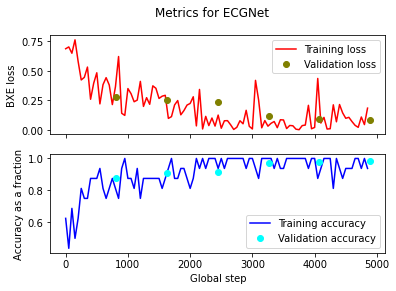

In [21]:
#Get total number of global steps
global_steps = (len(x_train)//batch_size) * epochs

# Plot stuff
f, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(range(global_steps)[::50], 
         losses[::50], 
         "r", label="Training loss")
axs[0].plot(np.arange(1, epochs + 1) * len(x_train)//batch_size, 
         global_vlosses, 
         "o", color="olive", label="Validation loss")
axs[0].set_ylabel("BXE loss")
axs[0].legend()

axs[1].plot(range(global_steps)[::50], 
         accs[::50], 
         "b", label="Training accuracy")
axs[1].plot(np.arange(1, epochs + 1) * len(x_train)//batch_size, 
         global_vaccs, 
         "o", color="cyan", label="Validation accuracy")
axs[1].set_ylabel("Accuracy as a fraction")
axs[1].legend()

f.suptitle("Metrics for ECGNet")
axs[1].set_xlabel("Global step")
plt.show()

# Great!! (or is it?) Let's check the test set!

In [22]:
taccs = []

x_test, y_test = shuffle(testing_set, testing_labels)

t = tqdm.trange(0, len(x_test), batch_size)
for step in t:
    ys = y_test[step:step + batch_size]
    ys = torch.from_numpy(np.array(ys)[..., np.newaxis]).float()
    xs = x_test[step:step + batch_size]
    xs = torch.from_numpy(np.array(xs).swapaxes(1, 2))
    ps = ecgnet(xs)
    taccs.append(accuracy(ps, ys))

print("Test set accuracy:")
print("Acc {:.04f}".format(np.mean(taccs, axis=0)))

  0%|          | 0/605 [00:00<?, ?it/s]/home/mike/.local/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 605/605 [00:02<00:00, 242.61it/s]

Test set accuracy:
Acc 0.8187


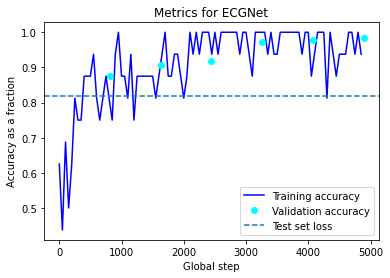

In [24]:
global_steps = (len(x_train)//batch_size) * 6
f, axs = plt.subplots(1, 1, sharex=True)
axs.plot(range(global_steps)[::50], 
         accs[::50], 
         "b", label="Training accuracy")
axs.plot(np.arange(1, epochs + 1) * len(x_train)//batch_size, 
         global_vaccs, 
         "o", color="cyan", label="Validation accuracy")
axs.axhline(np.mean(taccs, axis=0), linestyle="--", label="Test set loss")
axs.set_ylabel("Accuracy as a fraction")
axs.legend()

axs.set_title("Metrics for ECGNet")
axs.set_xlabel("Global step")
plt.show()

Not perfect, what else can we do?

# Other things we could try:

* Regularisation to reduce overfitting
* Other neural network architectures (i.e. ResNet, RevNet, RNN, ...)
* More data/more involved data preprocessing
* Change the data shape (i.e. a 2D CNN across all 12 channels?)